In [1]:
%load_ext autoreload

%autoreload 2

In [197]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from oracle import make_oracle
from optimize import optimize_newton, optimize_gd, optimize_hfn

from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

In [260]:
def plot_model(oracle, optimizers_param):
    model = LogisticRegression(penalty="none", tol=1e-8, max_iter=10000, n_jobs=-1, fit_intercept=False)
    model.fit(oracle.X, oracle.y.ravel())
    
    entropy_true = oracle.value(model.coef_.reshape(-1, 1))
    
    w_n = oracle.X.shape[1]
    w_init = np.random.uniform(-1/np.sqrt(w_n), 1/np.sqrt(w_n), size=(w_n, 1))
    
    fig, axs = plt.subplots(1, 3, figsize=(45, 12))
    
    for i, (name, optimizer, line_search_methods, log_modulo) in enumerate(optimizers_param):
        for line_search in line_search_methods:        
            w, log = optimizer(oracle, w_init, line_search_method=line_search, log_modulo=log_modulo)
            time, entropy, alpha, grad_info = log.get_log()

            n_iters = np.arange(time.shape[0]) * log_modulo
            
            axs[i].plot(n_iters, np.log(np.abs(entropy - entropy_true)), 
                        label=f"{line_search}: {np.round(np.min(entropy), 4)}")
    
    for ax, param in zip(axs.flat, optimizers_param):
        ax.set_title(param[0])
        ax.set(xlabel="iteration", ylabel="absolute error")
        ax.legend()

In [261]:
oracle = make_oracle()

optim_params = [
    ("gradien descent", optimize_gd, ["golden", "brent", "armijo", "wolfe", "lipschitz"], 100),
    ("newton", optimize_newton, ["golden", "brent", "armijo", "wolfe"], 1),
    ("hessian-free newton", optimize_hfn, ["golden", "brent", "armijo", "wolfe"], 1)
]

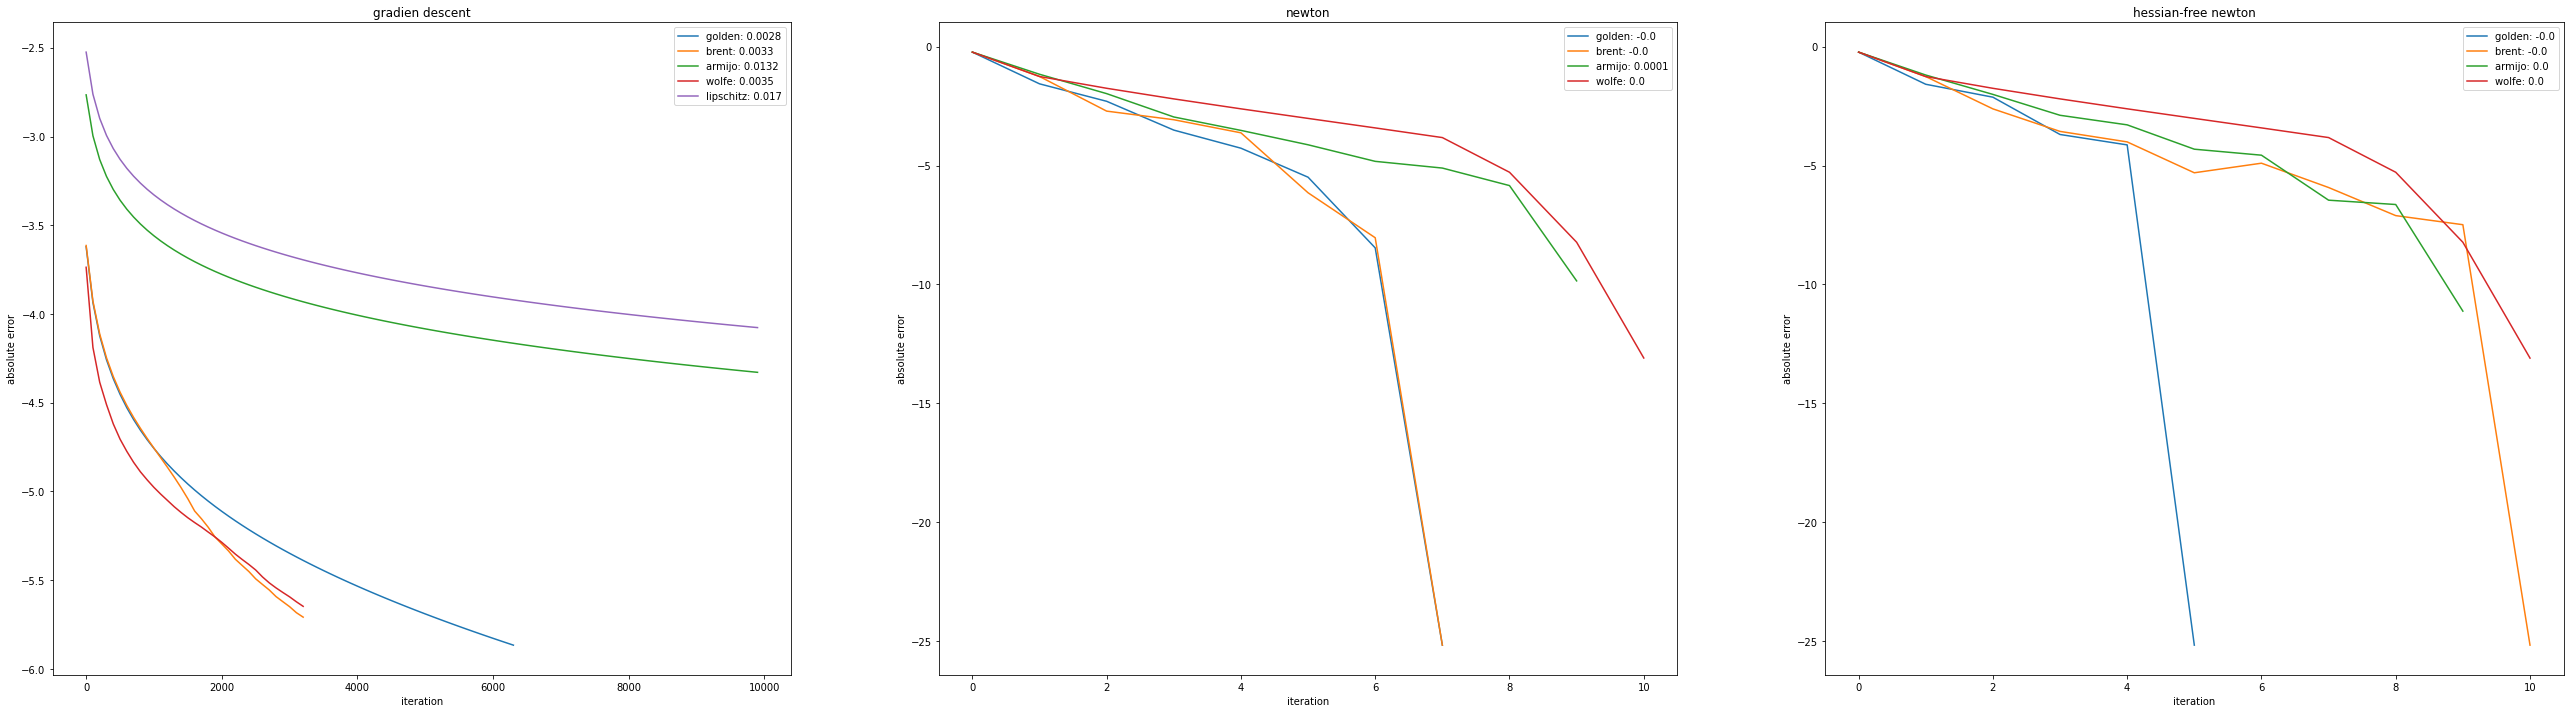

In [262]:
plot_model(oracle, optim_params)